In [1]:
! pip install tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import torch
import torch.distributions
import torch.nn as nn
from tqdm.auto import tqdm
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from torch.autograd import Variable
import pickle as pkl
import torch.optim as optim
from matplotlib import pyplot as plt
import torch
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split
import random
import os
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
#seed = 1
#np.random.seed(seed)
#torch.manual_seed(seed)

In [4]:
EPS = 1e-6

In [5]:
file = open('hw2_q2.pkl', 'rb')
images = pkl.load(file)

In [6]:
x_train = np.transpose(images['train'], [0, 3, 1, 2])
x_test = np.transpose(images['test'], [0, 3, 1, 2])

In [7]:
x_train.shape, x_test.shape

((20000, 3, 32, 32), (6838, 3, 32, 32))

In [47]:
class ResBlock(nn.Module):
    def __init__(self, in_num, filts_num=32):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_num, filts_num, (1, 1))
        self.conv2 = nn.Conv2d(filts_num, filts_num, (3, 3), padding=1)
        self.conv3 = nn.Conv2d(filts_num, in_num, (1, 1))
        
    def forward(self, x):
        c1 = self.conv1(x)
        r = torch.relu(c1)
        c2 = self.conv2(r)
        r = torch.relu(c2)
        c3 = self.conv3(r)
        return x + c3

In [48]:
class ResNet(nn.Module):
    def __init__(self, in_num=3, filts_num=32, blocks_num=4):
        super(ResNet, self).__init__()
        out_num = in_num * 2        
        self.conv1 = nn.Conv2d(in_num, filts_num, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(filts_num, out_num, (3, 3), padding=1)
        self.blocks = nn.ModuleList()
        for i in range(blocks_num):
            self.blocks.append(ResBlock(filts_num, filts_num))
        
    def forward(self, x):
        h = self.conv1(x)
        for block in self.blocks:
            h = block(h)
        relu = torch.relu(h)
        out = self.conv2(relu)
        return out

In [49]:
class CouplingLayer(nn.Module):
    def __init__(self, c=3, h=32, w=32, filts_num=32, blocks_num=4, mask=None):
        super(CouplingLayer, self).__init__()
        self.register_buffer("mask", torch.ones([1, c, h, w], dtype=torch.float32))
        self.mask.data.copy_(mask)
        self.res_net = ResNet(c, filts_num, blocks_num)
    
    def forward(self, x, rev=False):
        z = self.mask * x
        resnet = self.res_net(z)
        log_s, t = torch.split(resnet, z.shape[1], dim=1)
        log_s = torch.tanh(log_s)
        
        if rev:
            z = z + (1.0 - self.mask) * (x - t) / torch.exp(log_s)
            return z
        else:
            z = z + (1.0 - self.mask) * (torch.exp(log_s) * x + t)
            fl = torch.flatten(log_s * (1.0 - self.mask), start_dim=1)
            logdet = torch.sum(fl, dim=1, keepdim=True)
            return z, logdet

In [50]:
class ActNorm(nn.Module):
    def __init__(self, c, h, w):
        super(ActNorm, self).__init__()
        self.register_parameter("s", nn.Parameter(torch.ones([1, c, h, w])))
        self.register_parameter("b", nn.Parameter(torch.zeros([1, c, h, w])))
        
    def initialize(self, x):
        std = torch.std(x, dim=0, keepdim=True)
        self.s.data.copy_(1.0 / std)
        self.b.data.copy_(-torch.mean(x * self.s, dim=0, keepdim=True))
        
    def forward(self, x, rev=False):
        if rev:
            out = (x - self.b) / self.s
            return out
        else:
            lg = torch.log(torch.abs(self.s) + 1e-6)
            fl = torch.flatten(lg, start_dim=1)
            logdet = torch.sum(fl, dim=1, keepdim=True)
            out = x * self.s + self.b
            return out, logdet

In [51]:
def preprocess(x, alpha=0.05, rev=False):
    def logit(x, rev=False):
        if rev:
            return torch.exp(x) / (torch.exp(x) + 1.0)
        else:    
            t = torch.abs(1.0 / x + 1.0 / (1.0 - x))
            logdet = torch.log(t.flatten(start_dim=1) + EPS).sum(dim=1, keepdim=True)
            return torch.log(x) - torch.log(1.0 - x), logdet
    def dq(x, alpha=0.05, rev=False):
        if rev:
            return 4.0 * (x - alpha) / (1.0 - alpha)
        else:
            t = torch.ones_like(x) * (1.0 - alpha) / 4.0
            logdet = torch.log(torch.abs(t.flatten(start_dim=1))).sum(dim=1, keepdim=True)
            return alpha + (1.0 - alpha) * x / 4.0, logdet
    
    if rev:
        return dq(logit(x, rev), alpha, rev)
    else:
        deq, logdet1 = dq(x, alpha, rev)
        z, logdet2 = logit(deq, rev)
        return z, logdet1 + logdet2

In [52]:
def squeeze(x):
    n, c, h, w = x.shape
    return F.unfold(x, (2, 2), stride=2).reshape([n, 4 * c, h // 2, w // 2])

def unsqueeze(x):
    n, c, h, w = x.shape
    return F.fold(x.reshape([n, c, -1]), (h * 2, w * 2), (2, 2), stride=2)

In [53]:
class RealNVP(nn.Module):    
    def __init__(self):
        super(RealNVP, self).__init__()
        self.layers1 = nn.ModuleList()
        mask = self.build_checkerboard_mask(3, 32, 32)
        for _ in range(4):
            self.layers1.append(CouplingLayer(3, 32, 32, mask=mask))
            self.layers1.append(ActNorm(3, 32, 32))
            mask = 1.0 - mask
        
        self.layers2 = nn.ModuleList()
        mask = self.build_channel_split_mask(12, 16, 16)
        for _ in range(3):
            self.layers2.append(CouplingLayer(12, 16, 16, mask=mask))
            self.layers2.append(ActNorm(12, 16, 16))
            mask = 1.0 - mask
        
        self.layers3 = nn.ModuleList()
        mask = self.build_checkerboard_mask(12, 16, 16)
        for _ in range(3):
            self.layers3.append(CouplingLayer(12, 16, 16, mask=mask))
            self.layers3.append(ActNorm(12, 16, 16))
            mask = 1.0 - mask
            
        self.layers4 = nn.ModuleList()
        mask = self.build_channel_split_mask(48, 8, 8)
        for _ in range(3):
            self.layers4.append(CouplingLayer(48, 8, 8, mask=mask))
            self.layers4.append(ActNorm(48, 8, 8))
            mask = 1.0 - mask
            
        self.layers5 = nn.ModuleList()
        mask = self.build_checkerboard_mask(48, 8, 8)
        for i in range(3):
            self.layers5.append(CouplingLayer(48, 8, 8, mask=mask))
            self.layers5.append(ActNorm(48, 8, 8))
            mask = 1.0 - mask
            
    def forward(self, x, rev=False):
        if not rev:
            x, logdet = preprocess(x)
            for layer in self.layers1:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
                
            x = squeeze(x)
            for layer in self.layers2:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
            for layer in self.layers3:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet

            x = squeeze(x)
            for layer in self.layers4:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
            for layer in self.layers5:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet

            x = unsqueeze(x)
            x = unsqueeze(x)
            return x, logdet
        else:
            x = squeeze(x)
            x = squeeze(x)
            for layer in reversed(self.layers5):
                x = layer(x, rev=rev)
            for layer in reversed(self.layers4):
                x = layer(x, rev=rev)
            x = unsqueeze(x)
            for layer in reversed(self.layers3):
                x = layer(x, rev=rev)
            for layer in reversed(self.layers2):
                x = layer(x, rev=rev)
            x = unsqueeze(x)
            for layer in reversed(self.layers1):
                x = layer(x, rev=rev)
            x = preprocess(x, rev=rev)
            return x
        
    def build_checkerboard_mask(self, c, h, w):
        a = np.ones([1, c, h, w], dtype=np.bool)
        b = np.ones([1, c, h, w], dtype=np.bool)
        even_idx = np.arange(0, w, 2)
        odd_idx = np.arange(1, h, 2)
        a[:, :, odd_idx, :] = False 
        b[:, :, :, even_idx] = False
        return torch.from_numpy(a ^ b).float()
    
    def build_channel_split_mask(self, c, h, w):
        mask = torch.zeros([1, c, h, w], dtype=torch.float32)
        idx = [[4 * i, 4 * i + 1] for i in range(c // 4)]
        idx = np.array(idx).reshape(-1)
        mask[:, idx, :, :] = 1.0
        return mask

    def initialize(self, x):
        with torch.no_grad():
            x, _ = preprocess(x)
            for layer in self.layers1:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)    
                
            x = squeeze(x)
            for layer in self.layers2:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x,  _ = layer(x)
            for layer in self.layers3:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)
                
            x = squeeze(x)
            for layer in self.layers4:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)
            for layer in self.layers5:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)

In [54]:
def NLL_loss(z, logdet):
    m = torch.distributions.normal.Normal(0, 1)
    log_pz = m.log_prob(z) 
    log_pz = torch.sum(torch.flatten(log_pz, start_dim=1), dim=1, keepdim=True)
    nll = -(log_pz + logdet)
    return nll

In [55]:
BATCH_SIZE = 64
NUM_EPOCHS = 100
LR = 1e-3

In [57]:
dataloader = torch.utils.data.DataLoader(x_train, batch_size=BATCH_SIZE, shuffle=True)

val_steps = 30
logs = {}

net = RealNVP().cuda()
opt = optim.Adam(net.parameters(), lr=LR)

val_step = []
train_log = []
val_log = []
global_step = 0

sample_idx = np.random.choice(np.arange(0, x_train.shape[0]), 128)
init_batch = torch.from_numpy(x_train[sample_idx]).float().cuda()
net.initialize(init_batch)

for epoch in range(NUM_EPOCHS):
    for batch in dataloader:
        global_step += 1
        
        batch = batch.float().cuda()
        z, logdet = net(batch)
        nll = NLL_loss(z, logdet)
        loss = torch.sum(nll, dim=0)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (global_step - 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{NUM_EPOCHS} Iter {global_step}: Loss: {loss.item()}")
        train_nll = loss.detach() / (batch.shape[0] * 32 * 32 * 3 * np.log(2))
        train_log.append(train_nll.item())

        if ((global_step - 1) % val_steps == 0):
            with torch.no_grad():
                start_idx = 0
                val_size = x_test.shape[0]
                val_nll = torch.zeros([1]).float().cuda()
                while start_idx < val_size:
                    end_idx = min(val_size, start_idx + BATCH_SIZE)
                    val_z, val_logdet = net(torch.from_numpy(x_test[start_idx:end_idx]).float().cuda())
                    val_nll = val_nll + torch.sum(NLL_loss(val_z, val_logdet))
                    start_idx += BATCH_SIZE
                val_step.append(global_step - 1)
                val_log.append(val_nll.item() / (val_size * 32 * 32 * 3 * np.log(2)))

Epoch 1/100 Iter 1: Loss: 266875.25
Epoch 1/100 Iter 11: Loss: 120871.0703125
Epoch 1/100 Iter 21: Loss: 79076.328125
Epoch 1/100 Iter 31: Loss: 48974.45703125
Epoch 1/100 Iter 41: Loss: 26647.578125
Epoch 1/100 Iter 51: Loss: 25669.91015625
Epoch 1/100 Iter 61: Loss: 11327.111328125


KeyboardInterrupt: 

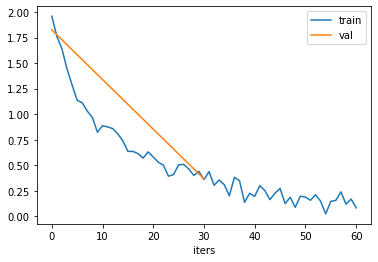

In [58]:
plt.plot(np.arange(len(train_log)), train_log, label="train")
plt.plot(val_step, val_log, label="val")
plt.xlabel("iters")
plt.legend()